In [1]:
import os
os.chdir("..")
import torch
from epilearn.models.Temporal.SIR import SIR, SEIR, SIS
from epilearn.models.SpatialTemporal.NetworkSIR import NetSIR
from epilearn.models.SpatialTemporal.DMP import DMP
from epilearn.models.Temporal.SIR import SIR
from epilearn.utils import utils, simulation
from epilearn.utils.simulation import Time_geo
from epilearn.data.dataset import UniversalDataset
from epilearn import visualize

### Generate random static graph

In [2]:
# generate random static graph
initial_graph = simulation.get_random_graph(num_nodes=15, connect_prob=0.4)
initial_states = torch.zeros(15,3) # [S,I,R]
initial_states[:, 0] = 1
# set infected individual: 3
initial_states[3, 0] = 0
initial_states[3, 1] = 1
initial_states[4, 0] = 0
initial_states[4, 1] = 1

### Initialize NetworkSIR model and perform simulation based on the generated inital graph

In [3]:
model = NetSIR(num_nodes=initial_graph.shape[0], horizon=120, infection_rate=0.05, recovery_rate=0.05) # infection_rate, recover_rate, fixed_population
preds = model(initial_states, initial_graph, steps = None)

In [4]:
preds.argmax(2).shape

torch.Size([120, 15])

### Plot simulation result at a certain time point

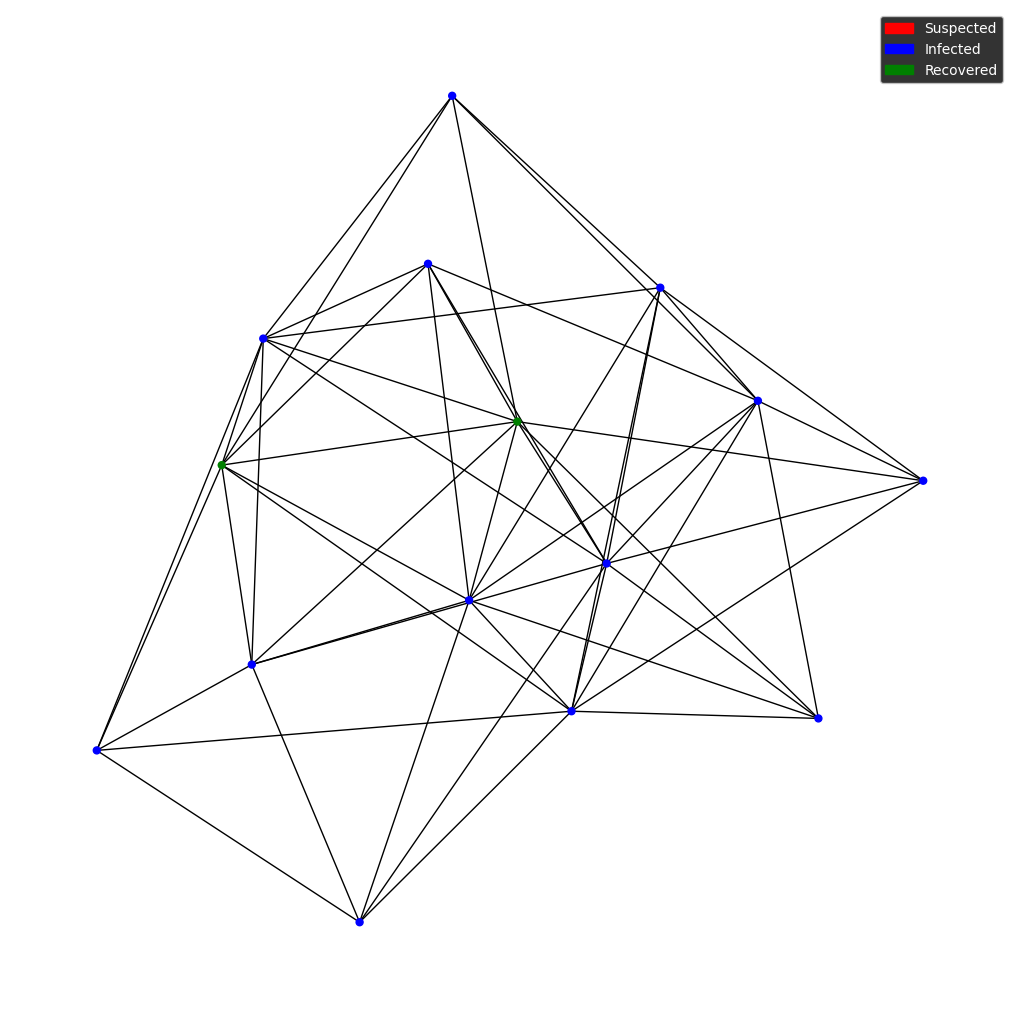

In [5]:
layout = visualize.plot_graph(preds.argmax(2)[15].detach().numpy(), initial_graph.to_sparse().indices().detach().numpy(), classes=['Suspected', 'Infected', 'Recovered'])

In [6]:
import torch
import numpy as np
import seaborn as sb
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

def plot_graph(states: np.array, graph : np.array, classes=None, layout=None):
    """
    Plots a graph using NetworkX where nodes are colored based on their state and annotated with class labels.
    The graph's layout can be specified; otherwise, a spring layout is used.

    Parameters
    ----------
    states : np.array
        Array containing the state of each node used to determine the color of nodes.
    graph : np.array
        A 2D array where each column represents an edge between two nodes (start and end).
    classes : list, optional
        List of class labels corresponding to each node. Default is None.
    layout : dict, optional
        A dictionary defining the position of each node for custom layouts. If None, a spring layout is used. Default is None.

    Returns
    -------
    dict
        The positions of the nodes in the plot, useful for customizing the layout or for further graphical analysis.
    """
    graph = [(graph[0, i], graph[1, i]) for i in range(len(graph[0]))]

    g = nx.Graph()
    g.add_nodes_from(range(len(states)))
    g.add_edges_from(graph)
    color_map = {
        0:'red',
        1:'blue',
        2:'green',
        3:'yellow',
        4:'purple'
    }
    colors = []
    labels = {}
    for node in states:
        colors.append(color_map[node])
        labels[node] = classes[node]

    plt.figure()

    if layout is not None:
        nx.draw(g, pos=layout, node_color=colors, font_size=10, node_size=100)
    else:
        pos = nx.spring_layout(g, seed=42)
        nx.draw(g, pos = pos, node_color=colors, font_size=10, node_size=100)

    patches = []
    for i, item in enumerate(color_map.items()):
        if i>=len(classes):
            break
        patches.append(mpatches.Patch(color=item[1], label=classes[item[0]]))


    plt.legend(handles=patches, fontsize=16)
    plt.show()

    return pos

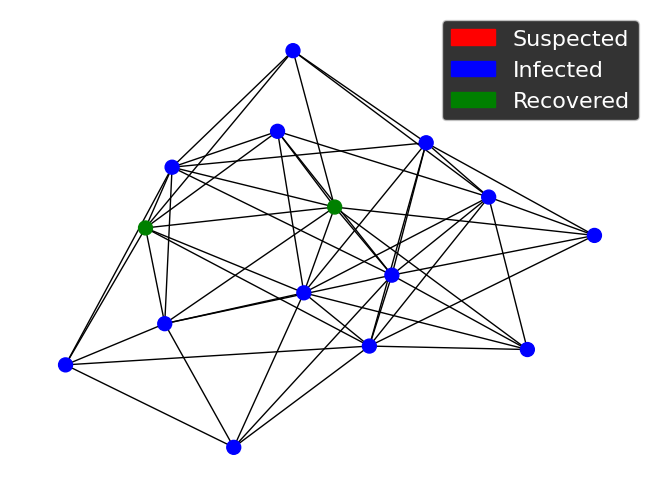

{0: array([0.61563729, 0.26285585]),
 1: array([-0.05597199, -0.20732441]),
 2: array([ 0.75626486, -0.48578297]),
 3: array([-0.63123062,  0.11119563]),
 4: array([0.05612294, 0.21378616]),
 5: array([-0.92182673, -0.56116945]),
 6: array([0.38859054, 0.52942707]),
 7: array([-0.1515341 ,  0.58573653]),
 8: array([-0.09539314,  0.98175   ]),
 9: array([-0.31064127, -0.9661354 ]),
 10: array([1.        , 0.07446072]),
 11: array([ 0.2639103, -0.120541 ]),
 12: array([ 0.18209589, -0.46883844]),
 13: array([-0.53465989,  0.40945217]),
 14: array([-0.56136408, -0.35887246])}

In [7]:
plot_graph(preds.argmax(2)[15].detach().numpy(), initial_graph.to_sparse().indices().detach().numpy(), classes=['Suspected', 'Infected', 'Recovered'])

### Simulate using Dynamic Message Passing (DMP)

In [8]:
recover = torch.rand(25)
dmp = DMP(num_nodes=25, recover_rate=recover)

In [9]:
# DMP is under maintaining...
# dmp_simulation = dmp(None, initial_graph)

### Simulate with SIR (above individual-level)

In [10]:
model = SIR(horizon=190, infection_rate=0.05, recovery_rate=0.05) # infection_rate, recover_rate, fixed_population
preds = model(initial_states.sum(0), steps = None)

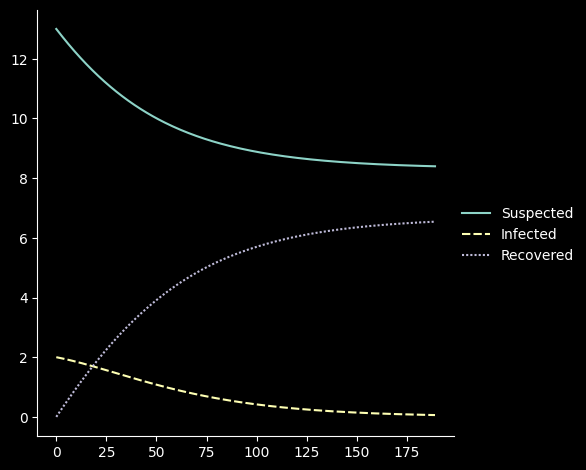

In [11]:
layout = visualize.plot_series(preds.detach().numpy(), columns=['Suspected', 'Infected', 'Recovered'])

### Construct graph from feature

In [12]:
feature = torch.rand(10,20)
adj = torch.randint(10,100, (10,10))
graph1 = simulation.get_graph_from_features(features=feature, adj=None)
graph2 = simulation.get_graph_from_features(features=feature, adj=adj)

In [13]:
graph1

tensor([[1.0000, 0.8274, 0.7247, 0.6753, 0.6766, 0.7366, 0.8363, 0.7600, 0.8145,
         0.7047],
        [0.8274, 1.0000, 0.6830, 0.7075, 0.6928, 0.7618, 0.7542, 0.7246, 0.8246,
         0.8729],
        [0.7247, 0.6830, 1.0000, 0.7617, 0.8234, 0.8729, 0.7681, 0.7547, 0.6496,
         0.6783],
        [0.6753, 0.7075, 0.7617, 1.0000, 0.6446, 0.7162, 0.7338, 0.7130, 0.7895,
         0.6137],
        [0.6766, 0.6928, 0.8234, 0.6446, 1.0000, 0.8011, 0.6775, 0.8187, 0.6838,
         0.7069],
        [0.7366, 0.7618, 0.8729, 0.7162, 0.8011, 1.0000, 0.7735, 0.6952, 0.7289,
         0.7558],
        [0.8363, 0.7542, 0.7681, 0.7338, 0.6775, 0.7735, 1.0000, 0.7418, 0.7570,
         0.6634],
        [0.7600, 0.7246, 0.7547, 0.7130, 0.8187, 0.6952, 0.7418, 1.0000, 0.7130,
         0.7734],
        [0.8145, 0.8246, 0.6496, 0.7895, 0.6838, 0.7289, 0.7570, 0.7130, 1.0000,
         0.7143],
        [0.7047, 0.8729, 0.6783, 0.6137, 0.7069, 0.7558, 0.6634, 0.7734, 0.7143,
         1.0000]])

In [14]:
graph2

tensor([[0.0256, 0.0103, 0.0086, 0.0250, 0.0088, 0.0164, 0.0239, 0.0079, 0.0271,
         0.0641],
        [0.0752, 0.0147, 0.0213, 0.0165, 0.0330, 0.0084, 0.0243, 0.0161, 0.0192,
         0.0873],
        [0.0268, 0.0081, 0.0125, 0.0110, 0.0087, 0.0213, 0.0698, 0.0087, 0.0118,
         0.0170],
        [0.0082, 0.0083, 0.0246, 0.0110, 0.0137, 0.0651, 0.0386, 0.0103, 0.0197,
         0.0267],
        [0.0423, 0.0103, 0.0187, 0.0068, 0.0102, 0.0348, 0.0089, 0.0115, 0.0096,
         0.0161],
        [0.0194, 0.0129, 0.0364, 0.0512, 0.0141, 0.0111, 0.0115, 0.0093, 0.0080,
         0.0184],
        [0.0167, 0.0204, 0.0256, 0.0193, 0.0071, 0.0516, 0.0139, 0.0076, 0.0126,
         0.0116],
        [0.0585, 0.0161, 0.0105, 0.0130, 0.0630, 0.0098, 0.0412, 0.0204, 0.0135,
         0.0079],
        [0.0452, 0.0092, 0.0135, 0.0108, 0.0085, 0.0091, 0.0081, 0.0135, 0.0169,
         0.0079],
        [0.0172, 0.0727, 0.0323, 0.0384, 0.0416, 0.0270, 0.0096, 0.0103, 0.0086,
         0.0139]])

### Simulate trace with TimeGEO

In [15]:
# prepare initial data
import numpy as np

data = {
    1: {
        0: {
            'loc': np.array([3744, 1901, 1995, 2653, 2743, 2744, 2654, 2743, 2745], dtype=int),
            'tim': np.array([6075.83333333, 6113.5, 6503.81666667, 6518.23333333, 6568.8, 6640.73333333, 6664.25, 6708.61666667, 6747.83333333], dtype=np.float64),
            'sta': np.array([37.66666667, 390.31666667, 14.41666667, 50.56666667, 71.93333333, 23.51666667, 44.36666667, 39.21666667, 99.75], dtype=np.float64)
        },
        1: {
            'loc': np.array([2653, 2744, 2654, 2653, 2654, 2653], dtype=int),
            'tim': np.array([297580.38333333, 297645.8, 297661.83333333, 297682.41666667, 297693.05, 297788.05], dtype=np.float64),
            'sta': np.array([65.41666667, 16.03333333, 20.58333333, 10.63333333, 95.0, 10.58333333], dtype=np.float64)
        }
    },
    3: {
        0: {
            'loc': np.array([2244, 2173, 2248, 2395, 2547, 2477, 1853], dtype=int),
            'tim': np.array([11740.61666667, 11757.53333333, 11778.65, 11819.31666667, 11833.56666667, 12035.68333333, 12064.13333333], dtype=np.float64),
            'sta': np.array([16.91666667, 21.11666667, 40.66666667, 14.25, 202.11666667, 28.45, 1383.16666667], dtype=np.float64)
        }
    },
    5: {
        0: {
            'loc': np.array([2741, 2654, 2653, 2743, 2341], dtype=int),
            'tim': np.array([89855.71666667, 89881.15, 89909.1, 90020.8, 90216.95], dtype=np.float64),
            'sta': np.array([25.43333333, 27.95, 111.7, 196.15, 34.91666667], dtype=np.float64)
        },
        1: {
            'loc': np.array([2653, 2744, 2653, 2823, 2744], dtype=int),
            'tim': np.array([236819.35, 236892.11666667, 236908.31666667, 236923.75, 237041.66666667], dtype=np.float64),
            'sta': np.array([72.76666667, 16.2, 15.43333333, 117.91666667, 32.93333333], dtype=np.float64)
        },
        2: {
            'loc': np.array([2653, 2652, 2744, 2653, 2743], dtype=int),
            'tim': np.array([75474.86666667, 75494.3, 75563.6, 75598.66666667, 75629.6], dtype=np.float64),
            'sta': np.array([19.43333333, 69.3, 35.06666667, 30.93333333, 142.6], dtype=np.float64)
        }
    }
}


In [16]:
def gen_gps_data():
    """
    Generates a set of GPS coordinates centered around a base location with random variations.
    
    The function initializes with a fixed random seed to ensure the data is reproducible. It sets up
    a base latitude and longitude, and defines maximum allowable variations in these values. It then
    generates a specified number of GPS points within these variation limits.
    
    Returns:
        numpy.ndarray: An array of shape (num_gps_points, 2) where each row contains the latitude
                       and longitude of a generated GPS point.
    """

    # Set the random seed for reproducibility
    np.random.seed(42)

    # Total number of GPS data points to generate
    num_gps_points = 4528

    # Base GPS coordinates around which the points will be generated
    base_latitude = 35.51168469
    base_longitude = 139.6733776

    # Maximum variation from the base coordinates
    latitude_variation = 0.0005  # Variation in latitude
    longitude_variation = 0.012  # Variation in longitude

    # Initialize an array to store the GPS data points
    gps_data = np.zeros((num_gps_points, 2))  # Each row will hold one latitude and one longitude

    # Generate random GPS data points
    for i in range(num_gps_points):
        random_latitude_shift = np.random.uniform(-latitude_variation, latitude_variation)
        random_longitude_shift = np.random.uniform(-longitude_variation, longitude_variation)
        gps_data[i][0] = base_latitude + random_latitude_shift  # Calculate the latitude
        gps_data[i][1] = base_longitude + random_longitude_shift  # Calculate the longitude

    return gps_data

In [17]:

class Parameters:
    def __init__(self, data_type):
        self.data_type = data_type

    def data_info(self, GPS):
        self.GPS = GPS
        self.tim_size = 1440

data_type = 'Example Data'
param = Parameters(data_type)

gps_data = gen_gps_data()
param.data_info(gps_data)

In [18]:
from tqdm import tqdm

def padding(traj, tim_size):
    def intcount(seq):
        a, b = np.array(seq[:-1]), np.array(seq[1:])
        return (a == a.astype(int)) + np.ceil(b) - np.floor(a) - 1
    locs = np.concatenate(([-1], traj['loc'], [-1]))
    tims = np.concatenate(([0], traj['tim'] % tim_size, [tim_size]))
    tims[-2] = tims[-1] if (tims[-2] < tims[-3]) else tims[-2]
    return np.concatenate([[locs[id]] * int(n) for id, n in enumerate(intcount(tims))]).astype(int)

def fixed(pad_traj, slot = 30):
    return np.array([np.argmax(np.bincount((pad_traj + 1)[(slot*i):(slot*i+slot)])) - 1 for i in range(int(len(pad_traj)/slot))])

def to_fixed(traj, tim_size, slot = 30):
    a = fixed(padding(traj, tim_size), slot)
    return np.where(a==-1, a[-1], a)

def to_std(traj, tim_size, detrans, time_slot=10):
    id = np.append(True, traj[1:] != traj[:-1])
    loc, tim = np.array(list(map(detrans,  traj[id]))), np.arange(0, tim_size, time_slot)[id]
    sta = np.append(tim[1:], tim_size) - tim
    return {'loc': loc, 'tim':tim, 'sta': sta}

def TimeGeo(data, param):
    TG = {}
    gen_bar = tqdm(data.items())
    for uid, trajs in gen_bar:
        gen_bar.set_description("TimeGeo - Generating trajectories for user: {}".format(uid))

        locations = np.sort(np.unique(np.concatenate([trajs[traj]['loc'] for traj in trajs])))
        trans = lambda x:np.where(locations == x)[0][0]
        detrans = lambda x:locations[x]

        input = np.array([to_fixed({'loc': list(map(trans, traj['loc'])), 'tim': traj['tim'], 'sta': traj['sta']}, param.tim_size, 10) for traj in trajs.values()])
        time_geo = Time_geo(param.GPS[np.ix_(locations)], np.bincount(input.flatten()) / np.cumprod(input.shape)[-1], simu_slot=param.tim_size//10)
        TG[uid] = {id: to_std(r['trace'][:, 0], param.tim_size, detrans) for id, r in enumerate(time_geo.pop_info)}
 
    return TG

In [19]:
simulated_data = TimeGeo(data, param)

TimeGeo - Generating trajectories for user: 5: 100%|██████████| 3/3 [00:06<00:00,  2.18s/it]
